# Data Preparation - COVID Cases and death counts per neighborhood

In [447]:
#import libraries
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

import folium  ## map rendering library

### Task
Use different data sources and APIs to collect information about the neigborhoods that can be used for segmentation.

In [390]:
#load NYC neighbourhood dataframe
NYC_pop_zip_df = pd.read_csv('NYC_neighbourhood.csv')

#check dataframe
NYC_pop_zip_df.head()

,Neighbourhood,borough,longitude,latitude,Population,ZIP Codes
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470"
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471"
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463


In [391]:
#split ZIP Codes column to obtain a single zip code per neighbourhood
NYC_pop_zip_df[['ZIP_CODE','ZIP_1', 'ZIP_2', 'ZIP_3', 'ZIP_4', 'ZIP_5', 'ZIP_6', 'ZIP_7']]= NYC_pop_zip_df['ZIP Codes'].str.split(',', expand=True)

#drop all zip columns except the first
NYC_pop_zip_df.drop(['ZIP_1', 'ZIP_2', 'ZIP_3', 'ZIP_4', 'ZIP_5', 'ZIP_6', 'ZIP_7'], axis = 1, inplace=True)

#check
NYC_pop_zip_df

,Neighbourhood,borough,longitude,latitude,Population,ZIP Codes,ZIP_CODE
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470",10466
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,10475
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,10471
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471",10463
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,10463
...,...,...,...,...,...,...,...
301,Sandy Ground,Staten Island,-74.217766,40.541140,33883.0,10309,10309
302,Roxbury,Queens,-73.892138,40.567376,2170.0,11697,11697
303,Lighthouse Hill,Staten Island,-74.137927,40.576506,8849.0,10306,10306
304,Hammels,Queens,-73.805530,40.587338,13029.0,11693,11693


In [392]:
NYC_pop_zip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Neighbourhood  306 non-null    object 
 1   borough        306 non-null    object 
 2   longitude      306 non-null    float64
 3   latitude       306 non-null    float64
 4   Population     306 non-null    float64
 5   ZIP Codes      306 non-null    object 
 6   ZIP_CODE       306 non-null    object 
dtypes: float64(3), object(4)
memory usage: 16.9+ KB


In [393]:
#convert ZIP_CODE column to int64 inorder to merge
NYC_pop_zip_df['ZIP_CODE'] = NYC_pop_zip_df['ZIP_CODE'].astype(int)

In [394]:
#left merge NYC_pop_zip_df with modzcta_mapping to get MODZCTA for each neighbourhood
NYC_pop_modzcta = NYC_pop_zip_df.merge(modzcta_mapping, how='left', on='ZIP_CODE')

#check
NYC_pop_modzcta

,Neighbourhood,borough,longitude,latitude,Population,ZIP Codes,ZIP_CODE,ZCTA,MODZCTA,PO_NAME,STATE
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470",10466,10466,10466,Bronx,NY
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,10475,10475,10475,Bronx,NY
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,10471,10471,10471,Bronx,NY
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471",10463,10463,10463,Bronx,NY
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,10463,10463,10463,Bronx,NY
...,...,...,...,...,...,...,...,...,...,...,...
301,Sandy Ground,Staten Island,-74.217766,40.541140,33883.0,10309,10309,10309,10309,Staten Island,NY
302,Roxbury,Queens,-73.892138,40.567376,2170.0,11697,11697,11697,11697,Breezy Point,NY
303,Lighthouse Hill,Staten Island,-74.137927,40.576506,8849.0,10306,10306,10306,10306,Staten Island,NY
304,Hammels,Queens,-73.805530,40.587338,13029.0,11693,11693,11693,11693,Far Rockaway,NY


In [395]:
#drop columns ZIP Codes, ZCTA, PO_NAME, STATE
NYC_pop_modzcta.drop(['ZIP Codes', 'ZCTA', 'PO_NAME', 'STATE'], axis = 1, inplace=True)

In [396]:
#check dataframe
NYC_pop_modzcta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Neighbourhood  306 non-null    object 
 1   borough        306 non-null    object 
 2   longitude      306 non-null    float64
 3   latitude       306 non-null    float64
 4   Population     306 non-null    float64
 5   ZIP_CODE       306 non-null    int64  
 6   MODZCTA        306 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 19.1+ KB


In [397]:
#check new dataframe
NYC_pop_modzcta.head(10)

,Neighbourhood,borough,longitude,latitude,Population,ZIP_CODE,MODZCTA
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,10466,10466
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,10475
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,10471
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,10463,10463
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,10463
5,Marble Hill,Manhattan,-73.910660,40.876551,9481.0,10463,10463
6,Norwood,Bronx,-73.879391,40.877224,40494.0,10467,10467
7,Williamsbridge,Bronx,-73.857446,40.881039,61321.0,10466,10466
8,Baychester,Bronx,-73.835798,40.866858,63345.0,10469,10469
9,Pelham Parkway,Bronx,-73.854756,40.857413,30073.0,10461,10461


In [445]:
#convert to csv
NYC_pop_modzcta.to_csv('NYC_pop_modzcta.csv', index=False)

In [446]:
#load NYC neighborhood-population-MODZCTA 
NYC_pop_modzcta = pd.read_csv('NYC_pop_modzcta.csv')

#check
NYC_pop_modzcta.head()

,Neighbourhood,borough,longitude,latitude,Population,ZIP_CODE,MODZCTA
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,10466,10466
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,10475
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,10471
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,10463,10463
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,10463


In [404]:
##using NYC OpenData source to get COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths by modzcta

covid_df = pd.read_csv('covid_data_by_modzcta.csv')

#check dataframe
covid_df.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,label,lat,lon,COVID_CONFIRMED_CASE_COUNT,COVID_PROBABLE_CASE_COUNT,COVID_CASE_COUNT,COVID_CONFIRMED_CASE_RATE,COVID_CASE_RATE,POP_DENOMINATOR,COVID_CONFIRMED_DEATH_COUNT,COVID_PROBABLE_DEATH_COUNT,COVID_DEATH_COUNT,COVID_CONFIRMED_DEATH_RATE,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,"10001, 10118",40.750693,-73.997137,6582,1480,8062,23836.52,29196.30,27613.09,51,6,57,184.70,206.42,11.79,54175
1,10002,Chinatown/Lower East Side,Manhattan,10002,40.715781,-73.986176,16932,3021,19953,22479.28,26490.02,75322.71,358,55,413,475.29,548.31,20.91,78460
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,10003,40.731825,-73.989164,12323,2094,14417,22829.75,26709.12,53977.81,74,13,87,137.09,161.18,16.76,70467
3,10004,Financial District,Manhattan,10004,40.703675,-74.013106,812,203,1015,27320.60,34150.75,2972.12,2,0,2,67.29,67.29,10.11,7827
4,10005,Financial District,Manhattan,10005,40.706092,-74.008861,1805,618,2423,20611.55,27668.58,8757.23,0,1,1,0.00,11.42,14.62,11857


In [405]:
#drop columns NEIGHBORHOOD_NAME, BOROUGH_GROUP, label, lat, lon, POP_DENOMINATOR, PERCENT_POSITIVE
covid_df.drop(['NEIGHBORHOOD_NAME', 'BOROUGH_GROUP', 'label', 'lat', 'lon', 'POP_DENOMINATOR','PERCENT_POSITIVE'], axis=1, inplace=True)

#check dataframe
covid_df.head()

,MODIFIED_ZCTA,COVID_CONFIRMED_CASE_COUNT,COVID_PROBABLE_CASE_COUNT,COVID_CASE_COUNT,COVID_CONFIRMED_CASE_RATE,COVID_CASE_RATE,COVID_CONFIRMED_DEATH_COUNT,COVID_PROBABLE_DEATH_COUNT,COVID_DEATH_COUNT,COVID_CONFIRMED_DEATH_RATE,COVID_DEATH_RATE,TOTAL_COVID_TESTS
0,10001,6582,1480,8062,23836.52,29196.30,51,6,57,184.70,206.42,54175
1,10002,16932,3021,19953,22479.28,26490.02,358,55,413,475.29,548.31,78460
2,10003,12323,2094,14417,22829.75,26709.12,74,13,87,137.09,161.18,70467
3,10004,812,203,1015,27320.60,34150.75,2,0,2,67.29,67.29,7827
4,10005,1805,618,2423,20611.55,27668.58,0,1,1,0.00,11.42,11857


In [406]:
##we are interested in actual confirmed cases based on testing
#drop columns COVID_PROBABLE_CASE_COUNT, COVID_CASE_COUNT, COVID_CASE_RATE, COVID_PROBABLE_DEATH_COUNT, COVID_DEATH_COUNT, COVID_DEATH_RATE

covid_df.drop(['COVID_PROBABLE_CASE_COUNT', 'COVID_CASE_COUNT', 'COVID_CASE_RATE', 'COVID_PROBABLE_DEATH_COUNT', 
               'COVID_DEATH_COUNT', 'COVID_DEATH_RATE'], axis = 1, inplace=True)

#check dataframe
covid_df.head()

,MODIFIED_ZCTA,COVID_CONFIRMED_CASE_COUNT,COVID_CONFIRMED_CASE_RATE,COVID_CONFIRMED_DEATH_COUNT,COVID_CONFIRMED_DEATH_RATE,TOTAL_COVID_TESTS
0,10001,6582,23836.52,51,184.70,54175
1,10002,16932,22479.28,358,475.29,78460
2,10003,12323,22829.75,74,137.09,70467
3,10004,812,27320.60,2,67.29,7827
4,10005,1805,20611.55,0,0.00,11857


In [407]:
#per documentation of the dataset, the rates are : Rate of confirmed cases per 100,000 people by MODZCTA
#so we will drop the count so we can calculate the count of cases and deaths in each neighborhood using it's population

covid_df.drop(['COVID_CONFIRMED_CASE_COUNT', 'COVID_CONFIRMED_DEATH_COUNT'], axis=1, inplace=True)

#check dataframe
covid_df.head()

,MODIFIED_ZCTA,COVID_CONFIRMED_CASE_RATE,COVID_CONFIRMED_DEATH_RATE,TOTAL_COVID_TESTS
0,10001,23836.52,184.70,54175
1,10002,22479.28,475.29,78460
2,10003,22829.75,137.09,70467
3,10004,27320.60,67.29,7827
4,10005,20611.55,0.00,11857


In [409]:
#rename MODIFIED_ZCTA Column to MODZCTA so we can merge to NYC_pop_modzcta dataframe
covid_df.rename(columns={"MODIFIED_ZCTA" : "MODZCTA"}, inplace=True)

#check
covid_df

,MODZCTA,COVID_CONFIRMED_CASE_RATE,COVID_CONFIRMED_DEATH_RATE,TOTAL_COVID_TESTS
0,10001,23836.52,184.70,54175
1,10002,22479.28,475.29,78460
2,10003,22829.75,137.09,70467
3,10004,27320.60,67.29,7827
4,10005,20611.55,0.00,11857
...,...,...,...,...
172,11691,26600.33,804.71,66752
173,11692,21893.44,589.66,18674
174,11693,22869.06,402.46,10292
175,11694,24962.22,529.37,18249


In [410]:
#left merge NYC_pop_modzcta to covid_df on MODZCTA
NYC_covid = NYC_pop_modzcta.merge(covid_df, how='left', on='MODZCTA')

#check
NYC_covid.head()

,Neighbourhood,borough,longitude,latitude,Population,ZIP_CODE,MODZCTA,COVID_CONFIRMED_CASE_RATE,COVID_CONFIRMED_DEATH_RATE,TOTAL_COVID_TESTS
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,10466,10466,21299.93,388.44,65398
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,10475,19781.32,669.20,37537
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,10471,21453.73,640.27,23352
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,10463,10463,21106.29,508.69,66378
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,10463,21106.29,508.69,66378


In [417]:
NYC_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighbourhood                306 non-null    object 
 1   borough                      306 non-null    object 
 2   longitude                    306 non-null    float64
 3   latitude                     306 non-null    float64
 4   Population                   306 non-null    float64
 5   ZIP_CODE                     306 non-null    int64  
 6   MODZCTA                      306 non-null    int64  
 7   COVID_CONFIRMED_CASE_RATE    306 non-null    float64
 8   COVID_CONFIRMED_DEATH_RATE   306 non-null    float64
 9   TOTAL_COVID_TESTS            306 non-null    int64  
 10  COVID_CONFIRMED_CASE_COUNT   306 non-null    float64
 11  COVID_CONFIRMED_DEATH_COUNT  306 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 31.1+ KB


In [416]:
#per documentation of the dataset, the rates are : Rate of confirmed cases per 100,000 people by MODZCTA
#compute COVID_CONFIRMED_CASE_COUNT and COVID_CONFIRMED_DEATH_COUNT per neighbourhood

NYC_covid['COVID_CONFIRMED_CASE_COUNT'] = (NYC_covid['COVID_CONFIRMED_CASE_RATE'] * NYC_covid['Population']) // 100000
NYC_covid['COVID_CONFIRMED_DEATH_COUNT'] = (NYC_covid['COVID_CONFIRMED_DEATH_RATE'] * NYC_covid['Population']) //100000

#check dataframe
NYC_covid.head()

,Neighbourhood,borough,longitude,latitude,Population,ZIP_CODE,MODZCTA,COVID_CONFIRMED_CASE_RATE,COVID_CONFIRMED_DEATH_RATE,TOTAL_COVID_TESTS,COVID_CONFIRMED_CASE_COUNT,COVID_CONFIRMED_DEATH_COUNT
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,10466,10466,21299.93,388.44,65398,6210.0,113.0
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,10475,19781.32,669.20,37537,8654.0,292.0
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,10471,21453.73,640.27,23352,706.0,21.0
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,10463,10463,21106.29,508.69,66378,10141.0,244.0
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,10463,21106.29,508.69,66378,2251.0,54.0


In [434]:
#convert to csv file
NYC_covid.to_csv('NYC_covid.csv', index=False)

### Task

Visualize the neigborhoods in the graph.

In [436]:
#define function to plot bar charts of the data
def bar_chart(data, group, field, title, x_label, y_label, calculation):
    """This function plots bar charts given 7 inputs:
    data: the dataframe to be plotted
    group: the column (in apostrophe) in the dataframe to groupby
    field: the column (in apostrophe) in the dataframe to perform an operation (sum or count) on
    title: the title of the bar chart (in apostrophe)
    x_label: label of the x-axis (in apostrophe)
    y_label: label of the y_axis (in apostrophe)
    calculation: sum or count operation (in apostrophe) to be computed on the field column provided
    """
    plt.figure(figsize=(9, 5))
    plt.title(title)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    
    if calculation == "count":
        data.groupby(group)[field].count().plot(kind='bar')
    
    if calculation == "sum":
        data.groupby(group)[field].sum().plot(kind='bar')

    plt.show()

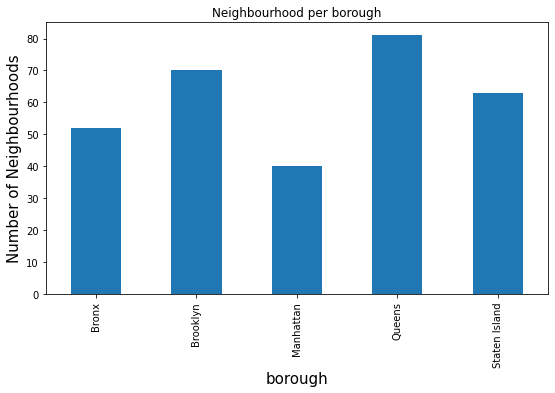

In [437]:
bar_chart(NYC_covid, 'borough', 'Neighbourhood', 'Neighbourhood per borough', 'Borough', 'Number of Neighbourhoods', 'count')

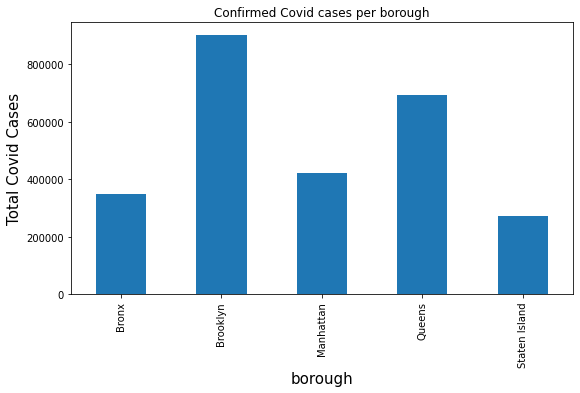

In [438]:
bar_chart(NYC_covid, 'borough', 'COVID_CONFIRMED_CASE_COUNT', 'Confirmed Covid cases per borough', 'Borough', 'Total Covid Cases', 'sum')

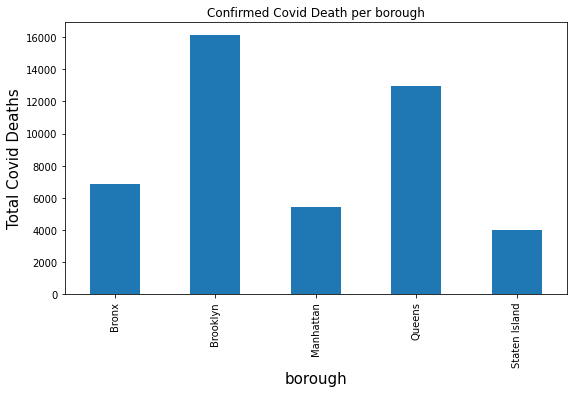

In [439]:
bar_chart(NYC_covid, 'borough', 'COVID_CONFIRMED_DEATH_COUNT', 'Confirmed Covid Death per borough', 'Borough', 'Total Covid Deaths', 'sum')

In [449]:
#get latitude, longitude of New York city
latitude = 40.730610
longitude  = -73.935242

# create map of NYC using latitude and longitude values
map_NYC = folium.Map(location=[latitude, longitude], zoom_start=10)

# add neighborhood markers to map
for lat, lng, borough, neighborhood in zip(cities_final['latitude'], cities_final['longitude'], cities_final['borough'], cities_final['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYC)  
    
map_NYC